# Buffer Stock Model

This notebooks shows you how to use the tools of the **consav** package to solve the canonical **buffer-stock consumption model** with either

1. **vfi**: standard value function iteration
* **nvfi**: nested value function iteration
* **egm**: endogenous grid point method

In all cases, each time step is solved using fully **Numba JIT compilled** code.

## Model equations

The models **bellman equation** is given by

$$ \begin{eqnarray}
v_{t}(p_{t},m_{t})&=& \max_{c_t}\frac{c^{1-\rho}}{1-\rho} + \beta v_{t+1}(p_{t+1},m_{t+1}) \\
& \text{s.t.} & \\ 
a_{t}&=&m_{t}-c_{t} \\
p_{t+1}&=&\psi_{t+1} p_{t} \\
\tilde{\xi}_{t+1} &=& \begin{cases}
\mu & \text{with prob.}\pi\\
\frac{\xi_{t+1}-\pi\mu}{1-\pi} & \text{else}
\end{cases} \\
m_{t+1}&=&R a_{t} + \tilde{\xi}_{t+1}p_{t+1}\\
a_t&\geq&0\\
\end{eqnarray}$$

where

$$ \begin{eqnarray}
\log\psi_{t+1} &\sim& \mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\
\log\xi_{t+1} &\sim& \mathcal{N}(-0.5\sigma_{\xi}^{2},\sigma_{\xi}^{2})
\end{eqnarray} $$

In the **last period** there is no continuation value

$$ \begin{eqnarray}
v_{T+1}(m_{T+1},p_{t+1}) &=& 0
\end{eqnarray} $$

The **post-decision** value function is

$$ \begin{eqnarray}
w_t(p_t,a_t) &=& \beta v_{t+1}(m_{t+1},p_{t+1})
\end{eqnarray} $$

The **Euler-equation** (required when solving with EGM) is 

$$ \begin{eqnarray}
C_{t}^{-\rho} &=& q_t(p_t,a_t) \\
 &=& \beta R \mathbb{E}_t[C_{t+1}(p_{t+1},m_{t+1})^{-\rho}] 
\end{eqnarray} $$

where $q_t(p_t,a_t)$ is the post-decision marginal value of cash

## Overview

The model solved in this notebook is written in **BufferStockModel.py**. 

It provides a class called **BufferStockModelClass** inheriting its basic interface from the **ConsumptionSavingModelClass**. 

A short **overview** of the interface is:

1. Each instance of the BufferStockModel class must have a **name** and a **solmethod** 
* The **save()** method saves the model naming it **data/name_solmethod**
* Three lists must be defined in the initialization:
  1. **parlist**; parameters, grids, etc. (model.par)
  2. **sollist**; solution variables (model.sol)
  3. **simlist**; simulation variables (model.sim)
* The **setup()** method defines baseline parameters
* The **setup_grids()** constructs grids for states and shocks
* The **solve()** method solves the model (\_solve_prep() allocates memory)
* The **simulate()** method simulates the model (\_simulate_prep() allocates memory)

In addition to **BufferStockModel.py**, this folder contains the following files:

1. **last_period.py**: calculate consumption and value funciton in last period
* **utility.py**: utility function and marginal utility function
* **post_decision.py**: calcualte $w$ and $q$
* **vfi.py**: solve with value function iteration
* **nvfi.py**: solve with nested value function iteration
* **egm.py**: solve with the endogenous grid method
* **simulate.py**: simulate for all solution methods
* **figs.py**: plot figures

The folder **cppfuncs** contains c++ functions not used in this notebook.

## Numba

Before (important!) you load **Numba** you can disable it or choose the numbe of threads as follows:

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

# Setup

In [2]:
%matplotlib inline

# reload module each time cell is run
%load_ext autoreload
%autoreload 2

# load the BufferStockModel module
from BufferStockModel import BufferStockModelClass

# First Example

The code is easiest to understand for **nvfi** and **do_simple_w = True**. The cell below solves the model using these settings. Go through the code the cell is calling to understand the interface.

In [3]:
# a. setup (calling the __init__ method) 
model = BufferStockModelClass(name='baseline',solmethod='nvfi',do_simple_w=True)

# b. print
print(model)

# b. solve
model.solve()

# c. simulate
print('')
model.simulate()

# d. save
model.save()       

Modelclass: BufferStockModelClass
Parameters:
 T = 5
 beta = 0.96
 rho = 2.0
 R = 1.03
 sigma_psi = 0.1
 Npsi = 6
 sigma_xi = 0.1
 Nxi = 6
 pi = 0.1
 mu = 0.5
 Nm = 600
 grid_m = [array of doubles]
 Np = 400
 grid_p = [array of doubles]
 Na = 800
 grid_a = [array of doubles]
 Nshocks = 30
 psi = [array of doubles]
 psi_w = [array of doubles]
 xi = [array of doubles]
 xi_w = [array of doubles]
 tol = 1e-08
 do_print = True
 do_simple_w = True
 cppthreads = 1
 simT = 5
 simN = 1000
 sim_seed = 1998

 t = 4 solved in 0.4 secs
 t = 3 solved in 4.3 secs (w: 1.2 secs)
 t = 2 solved in 2.8 secs (w: 0.5 secs)
 t = 1 solved in 2.8 secs (w: 0.5 secs)
 t = 0 solved in 2.8 secs (w: 0.5 secs)

model simulated in 0.8 secs


## Load/save

**Delete** the model:

In [4]:
del model

**Load** the model again:

In [5]:
model_loaded = BufferStockModelClass(name='baseline',solmethod='nvfi_alt',load=True)

**Plot** the consumption function in period $t=0$:

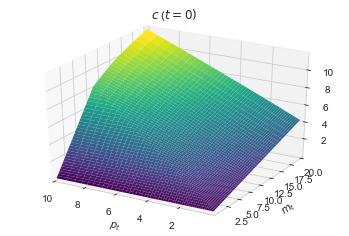

In [6]:
model_loaded.consumption_function(t=0)

**Plot** the life-cycle profiles:

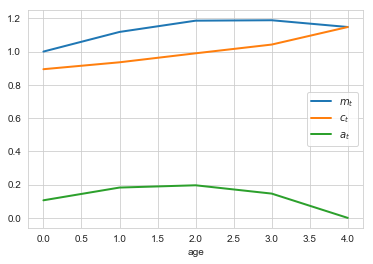

In [7]:
model_loaded.lifecycle()

**Plot** an interactive version of the consumption function:

In [8]:
model_loaded.consumption_function_interact()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_classes=('w…

# Timings

**Time** the various solution methods and show the importance of the optimized computation of $q_t(p,a)$ in EGM (i.e. setting `do_simple_w = False`).

In [9]:
for specs in [('nvfi',False),('nvfi',True),('egm',False),('egm',True),'vfi']:

    if len(specs) == 2:
        solmethod,do_simple_w = specs
    else:
        solmethod = specs
        do_simple_w = False # baseline

    # i. setup
    print(f'{solmethod}:')
    if do_simple_w:
        print('do_simple_w = True')
    model = BufferStockModelClass(solmethod=solmethod,do_print=False,do_simple_w=do_simple_w)

    # ii. test run
    model.solve()
    model.par.do_print = True

    # iii. final run
    model.solve()
    model.checksum()
    print('')

nvfi:
 t = 4 solved in 0.0 secs
 t = 3 solved in 1.9 secs (w: 0.1 secs)
 t = 2 solved in 1.8 secs (w: 0.0 secs)
 t = 1 solved in 1.8 secs (w: 0.0 secs)
 t = 0 solved in 1.9 secs (w: 0.0 secs)
checksum: 3.6670612847652317

nvfi:
do_simple_w = True
 t = 4 solved in 0.0 secs
 t = 3 solved in 2.9 secs (w: 0.5 secs)
 t = 2 solved in 2.7 secs (w: 0.5 secs)
 t = 1 solved in 2.8 secs (w: 0.5 secs)
 t = 0 solved in 2.8 secs (w: 0.5 secs)
checksum: 3.667061284694867

egm:
 t = 4 solved in 0.0 secs
 t = 3 solved in 0.2 secs (w: 0.2 secs)
 t = 2 solved in 0.1 secs (w: 0.1 secs)
 t = 1 solved in 0.1 secs (w: 0.1 secs)
 t = 0 solved in 0.1 secs (w: 0.1 secs)
checksum: 3.6669553712300376

egm:
do_simple_w = True
 t = 4 solved in 0.0 secs
 t = 3 solved in 0.8 secs (w: 0.8 secs)
 t = 2 solved in 0.8 secs (w: 0.8 secs)
 t = 1 solved in 0.8 secs (w: 0.8 secs)
 t = 0 solved in 0.8 secs (w: 0.8 secs)
checksum: 3.666955371230037

vfi:
 t = 4 solved in 0.0 secs
 t = 3 solved in 30.5 secs (w: 0.0 secs)
 t = 2

# More

See the notebook **Examples with run file and C++** for additional possibilities.